In [1]:
import copy
import json
import numpy as np
import torch
import torch.nn.utils.prune as prune
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from inspect_weights import load_weights
from vib_lenet_300_100_mnist import (
    VIBLeNet, MnistCsvDataset, train_test_split,
    batch_size, z_dim, evaluate
)
from testing_utils import get_device
from msc.plotting import plot_x_y
#%matplotlib widget

torch.manual_seed(42)
device = get_device()
print(f"using device: {device}")

using device: cpu
using device: cpu


In [2]:
model = VIBLeNet(z_dim=z_dim).to(device)
weights = load_weights(f"../weights/vib_lenet_300_100_mnist.pth", verbose=False)
model.load_state_dict(weights)

<All keys matched successfully>

In [15]:
dataset = MnistCsvDataset("../data/mnist_data.csv")
train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size
print(f"train_size: {train_size}, test_size: {test_size}")

_, test_dataset = random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

betas = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]

prune_layers = [
    ("encoder.0", 0.20), 
    ("encoder.2", 0.20),
    #("fc_mu", 0.10),
    #("fc_std", 0.10),
]

train_size: 56000, test_size: 14000


In [16]:
og_acc_list = []
pruned_acc_list = []
og_kll = []
pruned_kll = []
for b in tqdm(betas):
    pruned_model = copy.deepcopy(model)
    for layer_name, amount in prune_layers:
        module = dict(pruned_model.named_modules())[layer_name]
        prune.l1_unstructured(module, name="weight", amount=amount)

    _, og_test_acc, og_kl, ce = evaluate(model, test_loader, device, beta=b)
    _, pruned_test_acc, pruned_kl, ce = evaluate(pruned_model, test_loader, device, beta=b)
    og_acc_list.append(og_test_acc)
    pruned_acc_list.append(pruned_test_acc)
    og_kll.append(og_kl)
    pruned_kll.append(pruned_kl)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.60it/s]


In [17]:
for og, pruned, og_kl, pruned_kl in zip(og_acc_list, pruned_acc_list, og_kll, pruned_kll):
    print(f'diff: {pruned-og:.3f} -> og: {og:.3f}, pruned: {pruned:.3f}, og_kl: {og_kl}, pruned_kl: {pruned_kl}')

diff: 1.164 -> og: 93.314, pruned: 94.479, og_kl: 3.3243892192840576, pruned_kl: 3.9502925872802734
diff: 0.521 -> og: 93.586, pruned: 94.107, og_kl: 3.324390172958374, pruned_kl: 3.9502933025360107
diff: 0.814 -> og: 93.271, pruned: 94.086, og_kl: 3.3243892192840576, pruned_kl: 3.9502930641174316
diff: 1.193 -> og: 93.007, pruned: 94.200, og_kl: 3.324389696121216, pruned_kl: 3.9502930641174316
diff: 0.679 -> og: 93.507, pruned: 94.186, og_kl: 3.324389696121216, pruned_kl: 3.9502933025360107
diff: 1.186 -> og: 93.300, pruned: 94.486, og_kl: 3.3243889808654785, pruned_kl: 3.950293779373169
diff: 0.650 -> og: 93.429, pruned: 94.079, og_kl: 3.324389696121216, pruned_kl: 3.9502930641174316
diff: 1.164 -> og: 93.529, pruned: 94.693, og_kl: 3.324390172958374, pruned_kl: 3.9502933025360107
diff: 0.621 -> og: 93.357, pruned: 93.979, og_kl: 3.3243889808654785, pruned_kl: 3.9502925872802734


/tmp/ipykernel_950627/3224772291.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


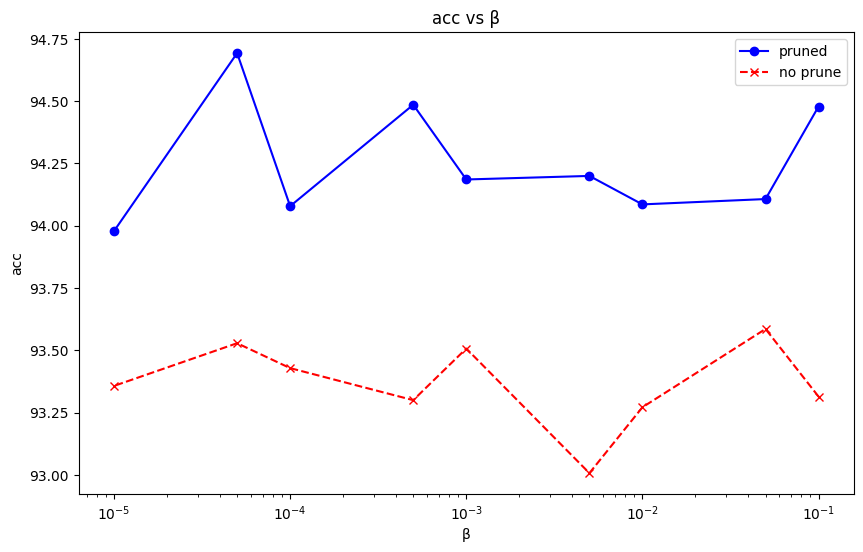

In [18]:
fig, ax = plot_x_y(betas, pruned_acc_list, og_acc_list, 'β', 'acc', 'pruned', 'no prune', True, False)
fig.savefig('../plots/vib_lenet_300_100_mnist_beta_vs_pruned_acc.png', dpi=300, bbox_inches='tight')
fig.show()